In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


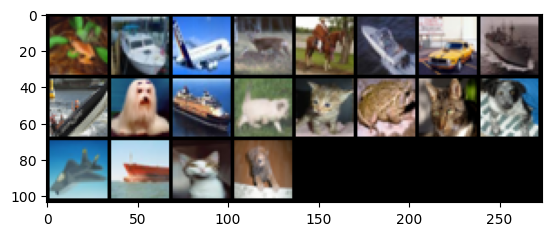

frog  ship  plane deer  horse ship  car   ship  ship  dog   ship  cat   cat   frog  cat   dog   plane ship  cat   dog  


In [22]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [24]:
def check_accuracy(model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Скачаем предобученную на датасете cifar10 модель resnet44

In [19]:
teacher = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet44", pretrained=True)
teacher.to(device)

Using cache found in C:\Users\Михаил/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet44-2a3cabcb.pt" to C:\Users\Михаил/.cache\torch\hub\checkpoints\cifar10_resnet44-2a3cabcb.pt
100%|█████████████████████████████████████████████████████████████████████████████| 2.62M/2.62M [00:00<00:00, 6.21MB/s]


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

Проверка точности

In [23]:
check_accuracy(teacher)

Accuracy of the network on the 10000 test images: 88 %


Создадим более компактную модель - ученика

In [27]:
class Net(nn.Module):
    def __init__(self, num_channels=3, dropout_rate=0.2):
        super(Net, self).__init__()
        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.num_channels*2)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.num_channels*4)

        self.fc1 = nn.Linear(4*4*self.num_channels*4, self.num_channels*4)
        self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 10)       
        self.dropout_rate = dropout_rate

    def forward(self, s):
        s = self.bn1(self.conv1(s))                        
        s = F.relu(F.max_pool2d(s, 2))                     
        s = self.bn2(self.conv2(s))                         
        s = F.relu(F.max_pool2d(s, 2)) 
        s = self.bn3(self.conv3(s))    
        s = F.relu(F.max_pool2d(s, 2)) 
        
        s = s.view(-1, 4*4*self.num_channels*4)

        s = F.dropout(F.relu(self.fcbn1(self.fc1(s))), 
            p=self.dropout_rate, training=self.training)
        s = self.fc2(s)     
        return s

Функция потерь при distillation

In [36]:
def loss_fn_kd(outputs, labels, teacher_outputs, T, alpha):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss

In [31]:
def accuracy(outputs, labels):
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs==labels)/float(labels.size)

In [64]:
def train_distillation(model, teacher_model, optimizer, dataloader, epochs):
    model.train()
    teacher_model.eval()
    l = len(dataloader)
    for epoch in range(epochs):
        losses = []
        accuracies=[]
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            train_batch, labels_batch = train_batch.to(device), labels_batch.to(device)
        
            output_batch = model(train_batch)
            with torch.no_grad():
                output_teacher_batch = teacher_model(train_batch)
            # temperature=2, alpha=0.5
            loss = loss_fn_kd(output_batch, labels_batch, output_teacher_batch, 2, 0.5)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            accuracies.append(accuracy(output_batch.detach().cpu().numpy(), labels_batch.detach().cpu().numpy()))
        print(f'[{epoch + 1}] loss: {np.mean(losses)} accuracy{np.mean(accuracies)}')

In [65]:
model = Net()
model = model.to(device)
optimizer = optim.Adam(model.parameters())

Обучим 10 эпох

In [66]:
train_distillation(model, teacher, optimizer, trainloader, 10)

[1] loss: 1.1791094251394272 accuracy0.3672
[2] loss: 1.0600841709375382 accuracy0.4330799999999999
[3] loss: 1.0252353020191192 accuracy0.45076000000000005
[4] loss: 1.0078558921337128 accuracy0.4640200000000001
[5] loss: 0.9976886615276337 accuracy0.47222
[6] loss: 0.9838758096218109 accuracy0.47752000000000006
[7] loss: 0.9716044853687287 accuracy0.48478000000000004
[8] loss: 0.9636330249071121 accuracy0.48948
[9] loss: 0.9600197627067566 accuracy0.49358
[10] loss: 0.9532434253573417 accuracy0.4967599999999999


точночть недостаточно высока, обучим ещё

In [68]:
train_distillation(model, teacher, optimizer, trainloader, 20)

[1] loss: 0.9410980832576752 accuracy0.50226
[2] loss: 0.9365935030937195 accuracy0.50382
[3] loss: 0.9399619394779205 accuracy0.5040399999999999
[4] loss: 0.932369323182106 accuracy0.50766
[5] loss: 0.9321978469848633 accuracy0.50738
[6] loss: 0.9332458309888839 accuracy0.50706
[7] loss: 0.9276690944552421 accuracy0.5099400000000001
[8] loss: 0.9247362231016159 accuracy0.51186
[9] loss: 0.9270169805288315 accuracy0.5125800000000001
[10] loss: 0.926883011174202 accuracy0.51034
[11] loss: 0.923991494846344 accuracy0.51446
[12] loss: 0.9219645479917526 accuracy0.51388
[13] loss: 0.9217816712856293 accuracy0.51326
[14] loss: 0.9216760014176368 accuracy0.51656
[15] loss: 0.9215305245161056 accuracy0.5127200000000001
[16] loss: 0.9161409776687622 accuracy0.5175
[17] loss: 0.9197099130868912 accuracy0.51648
[18] loss: 0.9184523222208023 accuracy0.5147200000000001
[19] loss: 0.9183375492095948 accuracy0.51698
[20] loss: 0.9144418751001357 accuracy0.5174


Точность на тестовом датасете

In [69]:
check_accuracy(model)

Accuracy of the network on the 10000 test images: 50 %


С каждой эпохой обучение происходит медленее, имеет смысл менять температуру и alpha

In [70]:
torch.save(model.state_dict(), "student")